# HEP Benchmark Query Q8

This follows the [IRIS-HEP benchmark](https://github.com/iris-hep/adl-benchmarks-index)
and the article [Evaluating Query Languages and Systems for High-Energy Physics Data](https://arxiv.org/abs/2104.12615)
and provides implementations of the benchmark tasks using Apache Spark.

The workload and data:
  - Benchmark jobs are implemented follwing [IRIS-HEP benchmark](https://github.com/iris-hep/adl-benchmarks-index)
  - The input data is a series of events from CMS opendata
  - The job output is typically a histogram 
  - See also https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics

Author and contact: Luca.Canali@cern.ch  
February, 2022

In [ ]:
# Start the Spark Session
# This uses local mode for simplicity
# The use of findspark is optional

import findspark
findspark.init("/home/luca/Spark/spark-3.2.1-bin-hadoop3.2")

from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("HEP benchmark")
         .master("local[4]")
         .config("spark.driver.memory", "4g")
         .config("spark.jars", "./scalaudf_2.12-0.1.jar")  # jar with the Scala UDFs
         .config("spark.jars.packages", "net.jafama:jafama:2.3.2")  # Faster math library for Scala UDFs
         .config("spark.sql.orc.enableNestedColumnVectorizedReader", "true")
         .getOrCreate()
        )


In [2]:
# Read data for the benchmark tasks
# download data as detailed at https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics

path = "/home/luca/HEP_benchmark/"
input_data = "Run2012B_SingleMu.orc"

df_events = spark.read.orc(path + input_data)

df_events.printSchema()

print(f"Number of events: {df_events.count()}")

root
 |-- run: integer (nullable = true)
 |-- luminosityBlock: long (nullable = true)
 |-- event: long (nullable = true)
 |-- HLT_IsoMu24_eta2p1: boolean (nullable = true)
 |-- HLT_IsoMu24: boolean (nullable = true)
 |-- HLT_IsoMu17_eta2p1_LooseIsoPFTau20: boolean (nullable = true)
 |-- PV_npvs: integer (nullable = true)
 |-- PV_x: float (nullable = true)
 |-- PV_y: float (nullable = true)
 |-- PV_z: float (nullable = true)
 |-- nMuon: long (nullable = true)
 |-- Muon_pt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_eta: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_phi: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_mass: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_charge: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- Muon_pfRelIso03_all: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- 

Number of events: 53446198


# Benchmark task Q8

For events with at least three light leptons and a same-flavor opposite-charge light lepton pair, find such a pair that has the invariant mass closest to 91.2 GeV in each event and plot the transverse mass of the system consisting of the missing tranverse momentum and the highest-$𝑝_𝑇$ light lepton not in this pair.

## Implementation: Filter in Spark, process in Scala UDF

In [3]:
# Select 3-Jet events and group Jet parameters together

df_events_q8 = ( df_events
                  .selectExpr("arrays_zip(Muon_pt, Muon_eta, Muon_phi, Muon_mass, Muon_charge) as Muon",
                              "arrays_zip(Electron_pt, Electron_eta, Electron_phi, Electron_Mass, Electron_charge) as Electron",
                              "MET_pt", "MET_phi")
                  .filter("nMuon + nElectron >= 3")
               )
                
df_events_q8.printSchema()

root
 |-- Muon: array (nullable = true)
 |    |-- element: struct (containsNull = false)
 |    |    |-- Muon_pt: float (nullable = true)
 |    |    |-- Muon_eta: float (nullable = true)
 |    |    |-- Muon_phi: float (nullable = true)
 |    |    |-- Muon_mass: float (nullable = true)
 |    |    |-- Muon_charge: integer (nullable = true)
 |-- Electron: array (nullable = true)
 |    |-- element: struct (containsNull = false)
 |    |    |-- Electron_pt: float (nullable = true)
 |    |    |-- Electron_eta: float (nullable = true)
 |    |    |-- Electron_phi: float (nullable = true)
 |    |    |-- Electron_Mass: float (nullable = true)
 |    |    |-- Electron_charge: integer (nullable = true)
 |-- MET_pt: float (nullable = true)
 |-- MET_phi: float (nullable = true)



In [4]:
# Register the Scala UDF
from pyspark.sql.types import FloatType

spark.udf.registerJavaFunction("diLeptonMt", "ch.cern.udf.diLeptonMt", FloatType())

In [5]:
q8 = df_events_q8.selectExpr("diLeptonMt(Muon, Electron, MET_pt, MET_phi) as transverse_mass")

q8.printSchema()
q8.show(5, False)

root
 |-- transverse_mass: float (nullable = true)

+---------------+
|transverse_mass|
+---------------+
|25.692127      |
|-1.0           |
|19.70266       |
|54.478092      |
|3.6868792      |
+---------------+
only showing top 5 rows



In [6]:
# compute the histogram of the transverse mass

min_val = 0
max_val = 200
num_bins = 100
step = (max_val - min_val) / num_bins

histogram_data = ( 
    q8
        .selectExpr(f"width_bucket(transverse_mass, {min_val}, {max_val}, {num_bins}) as bucket") 
        .groupBy("bucket")
        .count()
        .orderBy("bucket")
    )

# convert bucket number to the corresponding dimoun mass value
histogram_data = histogram_data.selectExpr(f"round({min_val} + (bucket - 1/2) * {step},2) as value", "count as N_events")


In [7]:
%time histogram_data_pandas=histogram_data.toPandas()


CPU times: user 266 ms, sys: 42.2 ms, total: 308 ms
Wall time: 21.9 s


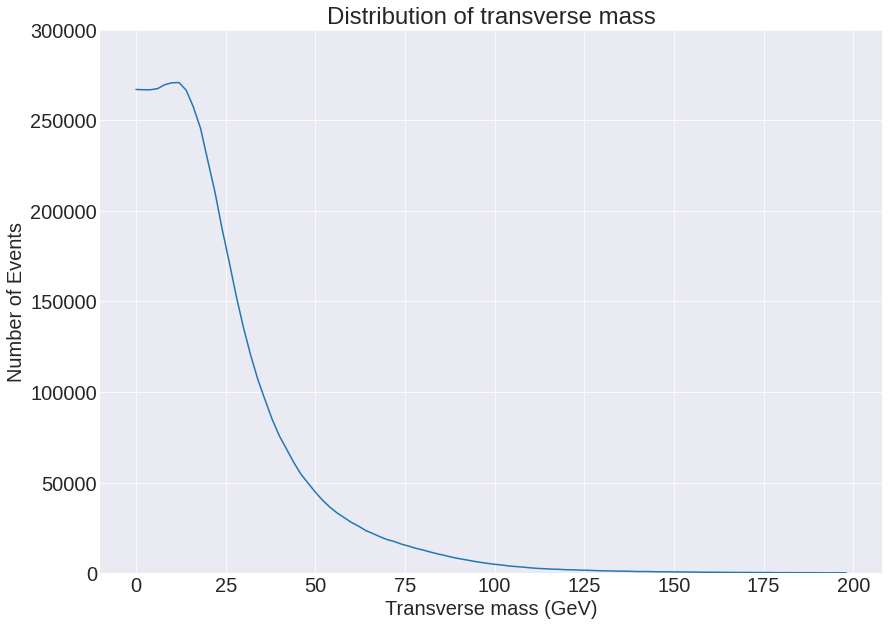

In [8]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["N_events"]

# line plot
f, ax = plt.subplots()
ax.plot(x, y, '-')

ax.set_xlabel('Transverse mass (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of transverse mass")
ax.set_ylim([0,300000])

plt.show()

In [9]:
spark.stop()